<a href="https://colab.research.google.com/github/dojian/classML/blob/main/Copy_of_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Large Language Models (LLM)

by (https://www.linkedin.com/in/joaquin-dominguez1992/) Joaquin Dominguez and John Santerre, PhD

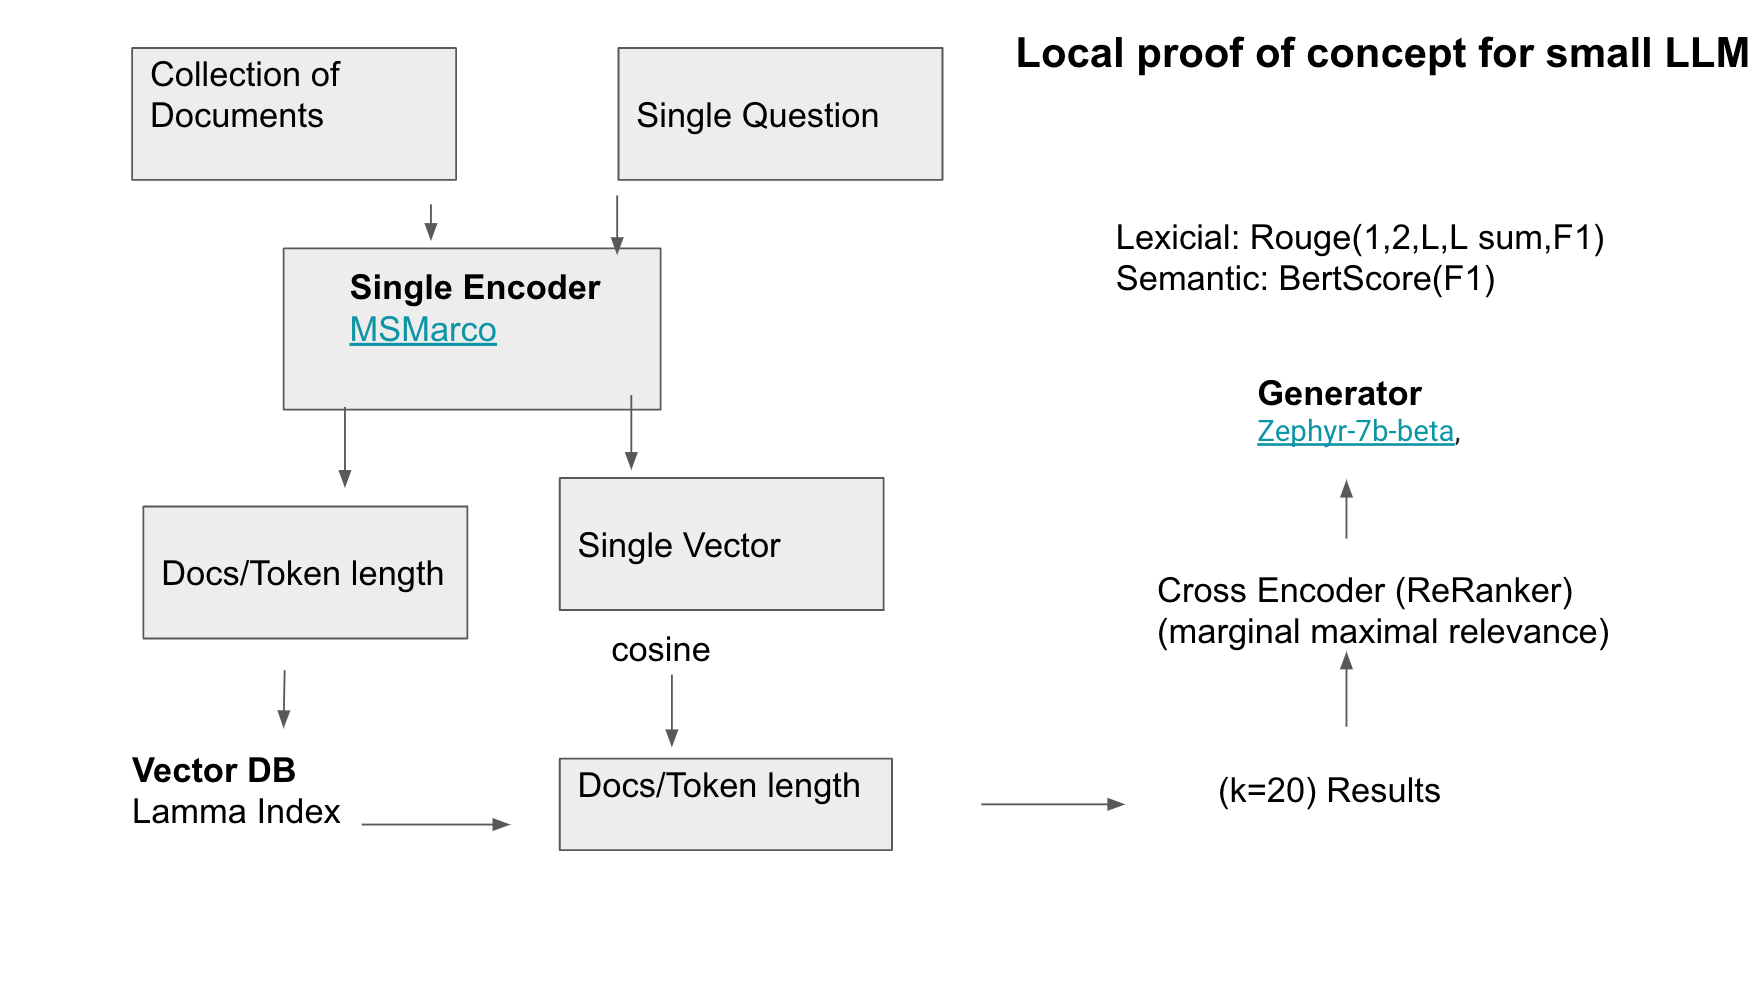

How to use this notebook: Every section requires different dependencies, model configurations, etc., so it is recommendable to start every section with a new restarted runtime, lest you might get an Out of Memory (OOM) error. All the dependencies for the notebook are found in the first code block. We are using models that require GPU, but will fit in the free-tier T4 GPU runtime.

Install dependencies.

In [ ]:
!pip install -q llama-index transformers accelerate bitsandbytes llama-hub newspaper3k

Large Language Models can be very powerful tools, but it is important to know how to leverage their strengths for valuable outputs. In this notebook, we'll review 4 different applications where LLMs can be and are frequently used in a production capacity. First, we'll review a couple of methods used in Retrieval Augmented Generation to use internal documents as context for Question Answering. Second, we'll explore summarization methods within the context limit of modern LLMs. Third, we'll generate tags that can be used for classification systems in internal databases. And lastly, we'll review an example of sentiment analysis to classify whether a given tweet is positive, neutral, or negative.

### Retrieval Augmented Generation (RAG)

With the advent of open-source foundation models (Llama, Bloom, Falcon, Mistral), companies and organizations with proprietary/confidential information had the opportunity to create an interactive agent to their data without being concerned about third parties accessing said data. While the remaining applications found in this notebook existed and were being used with the BERT-era models (albeit, to a less effective degree than today), RAG has been a relatively novel application that has been proven valuable by virtue of the increased efficacy of the larger models available today. Furthermore, it is an area that is being refined and optimized every day, with some of the methods we'll review here.

In its simplest form, RAG entails performing a cosine similarity search between the query and the vectorized form of a document text. The top n relevant chunks from the document are used as context and sent to the LLM as a prompt along with the query and task. The model is then able to use the context provided to [ideally] answer the question being asked. Every element of this process can be scaled, adapted, and optimized for the objective.

#### Form corpus
In the first example, we are using 3 articles found on CNN as our corpus. With respect to frameworks, we are using llama-index due to its reliable and feature-rich environment; however, this exact same process can be accomplished with other frameworks, such as Langchain or even without a framework. What is important here is to conceptually understand the points that tie together the pipeline.

In [ ]:
from llama_hub.web.news import NewsArticleReader

reader = NewsArticleReader(use_nlp=False)

urls=['https://lite.cnn.com/2023/11/01/tech/apple-ai-upgrades/index.html',
      'https://lite.cnn.com/2023/11/01/media/ai-chatbots-scraping-reporting-news-media-alliance/index.html',
      'https://lite.cnn.com/travel/day-of-the-dead-traditions-explained-cec/index.html'
      ]

docs = reader.load_data(urls)

In [ ]:
docs[1].text

'Source: CNN\n\nA top news media trade group is calling out A.I. technology companies for scraping news material to train their chatbots.\n\nThe News Media Alliance, which represents nearly 2,000 outlets in the U.S., published research Tuesday that found developers of generative artificial intelligence systems, such as OpenAI and Google, “have copied and used news, magazine, and digital media content to train” their bots. Importantly, the research indicated that A.I.\n\ncompanies have trained their bots to give far more credence to information published by those credible publishers versus material elsewhere across the web.\n\n“The research and analysis we’ve conducted shows that AI companies and developers are not only engaging in unauthorized copying of our members’ content to train their products, but they are using it pervasively and to a greater extent than other sources,” said Danielle Coffey, chief executive of the News Media Alliance, in a statement.\n\n“This shows they recogniz

We extract the relevant text from the links using the 'UnstructuredURLLoader plugin and load them into a Document class. An example of the second article is found below.

In [ ]:
docs[1]

Document(id_='ca0ab549-debb-45e7-80e4-9752a4df4370', embedding=None, metadata={'title': 'AI Chatbots are scraping news reporting and copyrighted content, News Media Alliance says', 'link': 'https://lite.cnn.com/2023/11/01/media/ai-chatbots-scraping-reporting-news-media-alliance/index.html', 'authors': ['Oliver Darcy'], 'language': 'en', 'description': '', 'publish_date': datetime.datetime(2023, 11, 1, 0, 0)}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, hash='bd9e93e494d1175ea74240212d9597a26f1728a76e3c1b93ad39f87e76b26b9e', text='Source: CNN\n\nA top news media trade group is calling out A.I. technology companies for scraping news material to train their chatbots.\n\nThe News Media Alliance, which represents nearly 2,000 outlets in the U.S., published research Tuesday that found developers of generative artificial intelligence systems, such as OpenAI and Google, “have copied and used news, magazine, and digital media content to train” their bots. I

#### Chunk
Although these articles are relatively short, we sometimes work with documents that are quite lengthy, so it is important to split the documents into chunks, so that what is sent to the model will hold only enough information to have the answer and provide sufficient context. In this case, we will split at the token level at 500 tokens per chunk with a 20 token overlap between chunks. This is a pretty standard place to begin, but this can and should be adjusted based on your documents and objective.

In [ ]:
from llama_index.node_parser import SimpleNodeParser

# Assuming documents have already been loaded

# Initialize the parser
parser = SimpleNodeParser.from_defaults(chunk_size=500, chunk_overlap=20)

# Parse documents into nodes
nodes = parser.get_nodes_from_documents(docs)

Below is an example of a chunk from one of the documents.

In [ ]:
nodes[3]

TextNode(id_='561089ba-5b96-4933-bed8-3127b9547dba', embedding=None, metadata={'title': 'AI Chatbots are scraping news reporting and copyrighted content, News Media Alliance says', 'link': 'https://lite.cnn.com/2023/11/01/media/ai-chatbots-scraping-reporting-news-media-alliance/index.html', 'authors': ['Oliver Darcy'], 'language': 'en', 'description': '', 'publish_date': datetime.datetime(2023, 11, 1, 0, 0)}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='ca0ab549-debb-45e7-80e4-9752a4df4370', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'title': 'AI Chatbots are scraping news reporting and copyrighted content, News Media Alliance says', 'link': 'https://lite.cnn.com/2023/11/01/media/ai-chatbots-scraping-reporting-news-media-alliance/index.html', 'authors': ['Oliver Darcy'], 'language': 'en', 'description': '', 'publish_date': datetime.datetime(2023, 11, 1, 0, 0)}, hash='bd9e93e494d1175ea7424021

#### Load Model
In this code block, we define the model we would like to use along with its configuration and prompt template. The T4 GPU only has 16GB vRAM, so in order to use a 7B parameter model (which is on the lower end size-wise), we need to quantize the weights, so that it fits.

For the prompt, we define the system instructions, as well as the format that this specific model is expecting. This will vary between models, so if you'd like to test out different models (I highly suggest you do so), make sure to review the documentation. For this example, we will be using  [Zephyr-7b-beta](https://huggingface.co/HuggingFaceH4/zephyr-7b-beta), as it was recently released and has been performing exceptionally for its size!

In [ ]:
import torch
from transformers import BitsAndBytesConfig
from llama_index.prompts import PromptTemplate
from llama_index.llms import HuggingFaceLLM

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)


def messages_to_prompt(messages):
  prompt = """You are an AI assistant that answers questions in a friendly manner, based on the given source documents. Here are some rules you always follow:
- Generate human readable output, avoid creating output with gibberish text.
- Generate only the requested output, don't include any other language before or after the requested output.
- Never say thank you, that you are happy to help, that you are an AI agent, etc. Just answer directly.
- Generate professional language typically used in business documents in North America.
- Never generate offensive or foul language.
"""
  for message in messages:
    if message.role == 'system':
      prompt += f"<|system|>\n{message.content}</s>\n"
    elif message.role == 'user':
      prompt += f"<|user|>\n{message.content}</s>\n"
    elif message.role == 'assistant':
      prompt += f"<|assistant|>\n{message.content}</s>\n"

  # ensure we start with a system prompt, insert blank if needed
  if not prompt.startswith("<|system|>\n"):
    prompt = "<|system|>\n</s>\n" + prompt

  # add final assistant prompt
  prompt = prompt + "<|assistant|>\n"

  return prompt


llm = HuggingFaceLLM(
    model_name="HuggingFaceH4/zephyr-7b-beta",
    tokenizer_name="HuggingFaceH4/zephyr-7b-beta",
    query_wrapper_prompt=PromptTemplate("<|system|>\n</s>\n<|user|>\n{query_str}</s>\n<|assistant|>\n"),
    context_window=3900,
    max_new_tokens=256,
    model_kwargs={"quantization_config": quantization_config},
    # tokenizer_kwargs={},
    generate_kwargs={"temperature": 0.7, "top_k": 50, "top_p": 0.95},
    messages_to_prompt=messages_to_prompt,
    device_map="auto",
)


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

#### Create Embeddings
For the 'Retrieval' part, we need to vectorize the text from the chunks and store them in a vector space. There are a number of embedding models that can be used for this task and their performance may vary based on the kind of task and data being used. In this case, we will use ['msmarco-distilbert-dot-v5'](https://huggingface.co/sentence-transformers/msmarco-distilbert-dot-v5) from Microsoft due to its proven track record in this task. Similarly, this is an area where you can explore different options. It is important to note, however, that there is two kinds of retrieval search functions that are generally used: cosine similarity and dot product search. This model, in particular, is optimized for dot product search (though it will perform fine if used with cosine similarity).

Since we are working with a small corpus (3 news articles), it is fine to store the vector database in memory, but for more reliable and scalable solutions, it is recommended to use vector databases, such as [Milvus](https://milvus.io/) or [Pinecone](https://www.pinecone.io/).

In [ ]:
from llama_index import ServiceContext

# this function allows us to specify our preference of embedding and llm. If not specified, it will default to OpenAI model, which requires API key.
service_context = ServiceContext.from_defaults(llm=llm, embed_model="local:sentence-transformers/msmarco-distilbert-dot-v5")

In [ ]:
from llama_index.response.notebook_utils import display_response

import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

In [ ]:
from llama_index.schema import TextNode
nodes_txt = [TextNode(text=x.text) for x in nodes]

In [ ]:
parser = SimpleNodeParser.from_defaults(chunk_size=500, chunk_overlap=20)

# Parse documents into nodes
nodes = parser.get_nodes_from_documents(nodes_txt)

In [ ]:
from llama_index import VectorStoreIndex

# This function creates the vector database from the embedded chunks
vector_index = VectorStoreIndex(nodes, service_context=service_context)

Using frameworks, as we're doing here can be valuable since it abstracts many of the finer details of the RAG pipeline for simplicity, but we may also be missing out on a lot of great intervention points for optimization. The defaults work fine, as you will see, but what if we want to specify that we would like 3 chunks retrieved instead of 2? What if we want to specify a different search function? Granted, all those things can be configured via these frameworks, but it is easy to forget about the finer details because these few lines of code gave us an already powerful application of our data!

In [ ]:
# This function initializes the pipeline from query to output
query_engine = vector_index.as_query_engine(response_mode="refine")

# Feel free to change this query as you please to ask questions about the articles we ingested.
response = query_engine.query("What is Apple's announcement?")

display_response(response)
# response.print_response_stream()

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should se

**`Final Response:`** The article discusses Apple's announcement of the M3 chip for its MacBook Pro and iMac lines, which is expected to solidify the company's commitment to integrating artificial intelligence (AI) into its products. This announcement comes at a time when Apple is gaining ground in the traditional PC and laptop market but still ranks fourth in terms of product shipments. The M3 chip is said to make complex tasks such as DNA/RNA sequencing and galaxy mapping more accessible, potentially aiding in early cancer detection and pandemic prevention. While the overall PC market has declined, Apple shipped approximately 26 million Macs in 2022, making up 9.1% of the market. The company is looking to the new iPhone 15 to provide a revenue boost, but demand is reportedly tepid, particularly in China.

In this example of RAG, we have used the Llama-index framework to:
- ingest a set of documents (news articles)
- process documents by chunking
- create embeddings of chunks with specified model
- create vector database from chunk embeddings
- retrieve top n relevant chunks based on query using dot product search
- use specified LLM to generate response to query, given the context of retrieved chunks

#### More RAG (Optional)

In this section, we are going to explore one optimization method in a RAG pipeline that is called Reranking. The premise of this method is that whereas in the simple example we did above, the search function is the arbiter of relevance for chunks, reranking introduces a second layer of chunk ranking; namely, by having the llm decide the ranking itself. For example, instead of having the dot product/cosine similarity search function return the top 2-3 chunks, here we will have it return the top 10 chunks and have the llm rank those chunks by importance and then choose the top 2 for context. For queries that require a finer degree of specificity and documents that are more elaborate, this approach may be worthwile to implement.

In [ ]:
import nest_asyncio

nest_asyncio.apply()

In [ ]:
import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))
from llama_index import (
    VectorStoreIndex,
    download_loader,
    ServiceContext,
)
from llama_index.indices.postprocessor import LLMRerank
from llama_index.llms import OpenAI
from IPython.display import Markdown, display


For this example, we will use the text of the novel, The Great Gatsby by F. Scott Fitzgerald, ingesting the text as we did above.

In [ ]:
from llama_index import download_loader

BeautifulSoupWebReader = download_loader("BeautifulSoupWebReader")

loader = BeautifulSoupWebReader()
docs = loader.load_data(urls=['https://www.gutenberg.org/files/64317/64317-h/64317-h.htm'])

Unfortunately, for formatting reasons, this method in Llama-index only currently works with OpenAI models, so for this example, you would have to specify your OpenAI API key, which is easily obtained. Hopefully, this gets fixed by the Llama-index team soon.

In [ ]:
import os
os.environ['OPENAI_API_KEY'] =  "put API key here"


In [ ]:
llm = OpenAI(temperature=0, model="gpt-3.5-turbo")

As we did in the prior example, we specify our preferred embedding model and created a vector store of the embedded chunks.

In [ ]:
service_context = ServiceContext.from_defaults(llm=llm, chunk_size=500, embed_model="local:sentence-transformers/msmarco-distilbert-dot-v5")
index = VectorStoreIndex.from_documents(docs, service_context=service_context)

The functions below is where the real "magic" happens.

In [ ]:
from llama_index.indices.postprocessor import LLMRerank
from llama_index.retrievers import VectorIndexRetriever
from llama_index.indices.query.schema import QueryBundle
import pandas as pd
from IPython.display import display, HTML


pd.set_option("display.max_colwidth", -1)


# in this function, we specify how many chunks we want retrieved from the vector space search function
# and how many we want the llm to return from those chunks.

def get_retrieved_nodes(
    query_str, vector_top_k=10, reranker_top_n=3, with_reranker=False
):
    query_bundle = QueryBundle(query_str)
    # configure retriever
    retriever = VectorIndexRetriever(
        index=index,
        similarity_top_k=vector_top_k,
    )
    retrieved_nodes = retriever.retrieve(query_bundle)

    if with_reranker:
        # configure reranker
        reranker = LLMRerank(
            choice_batch_size=5,
            top_n=reranker_top_n,
            service_context=service_context,
        )
        retrieved_nodes = reranker.postprocess_nodes(
            retrieved_nodes, query_bundle
        )

    return retrieved_nodes


def pretty_print(df):
    return display(HTML(df.to_html().replace("\\n", "<br>")))


def visualize_retrieved_nodes(nodes) -> None:
    result_dicts = []
    for node in nodes:
        result_dict = {"Score": node.score, "Text": node.node.get_text()}
        result_dicts.append(result_dict)

    pretty_print(pd.DataFrame(result_dicts))

<ipython-input-20-10b08fa27579>:8: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


To provide a usecase where this method could be used, lets try to find out who was to blame for the infamous accident that killed Myrtle in the story.

In [ ]:
new_nodes = get_retrieved_nodes(
    "Who was driving the car that hit Myrtle?",
    vector_top_k=3,
    with_reranker=False,
)

We request the top 3 chunks from the vector space, as usual. As we can see, the answer that we're looking for does get returned, but it is in the second chunk--specifically, in the section that states "...Was Daisy driving? Yes, he said after a moment, but of course I'll say I was." The 1st and 3rd chunks mention a car and gasoline pump, which is why they were returned, but they don't have the answer that we want. Let's see if the reranking method fares better.

In [ ]:
visualize_retrieved_nodes(new_nodes)

,Score,Text
0,0.717738,"“Was Daisy driving?”\r\r“Yes,” he said after a moment, “but of course I’ll say I was. You see, when we left New York she was very nervous and she thought it would steady her to drive—and this woman rushed out at us just as we were passing a car coming the other way. It all happened in a minute, but it seemed to me that she wanted to speak to us, thought we were somebody she knew. Well, first Daisy turned away from the woman toward the other car, and then she lost her nerve and turned back. The second my hand reached the wheel I felt the shock—it must have killed her instantly.”\r\r“It ripped her open—”\r\r“Don’t tell me, old sport.” He winced. “Anyhow—Daisy stepped on it. I tried to make her stop, but she couldn’t, so I pulled on the emergency brake. Then she fell over into my lap and I drove on.\r\r“She’ll be all right tomorrow,” he said presently. “I’m just going to wait here and see if he tries to bother her about that unpleasantness this afternoon. She’s locked herself into her room, and if he tries any brutality she’s going to turn the light out and on again.”\r\r“He won’t touch her,” I said. “He’s not thinking about her.”\r\r“I don’t trust him, old sport.”\r\r“How long are you going to wait?”\r\r“All night, if necessary. Anyhow, till they all go to bed.”\r\rA new point of view occurred to me. Suppose Tom found out that Daisy had been driving. He might think he saw a connection in it—he might think anything."
1,0.683213,"“Hasn’t got any name.”\r\rA pale well-dressed negro stepped near.\r\r“It was a yellow car,” he said, “big yellow car. New.”\r\r“See the accident?” asked the policeman.\r\r“No, but the car passed me down the road, going faster’n forty. Going fifty, sixty.”\r\r“Come here and let’s have your name. Look out now. I want to get his name.”\r\rSome words of this conversation must have reached Wilson, swaying in the office door, for suddenly a new theme found voice among his grasping cries:\r\r“You don’t have to tell me what kind of car it was! I know what kind of car it was!”\r\rWatching Tom, I saw the wad of muscle back of his shoulder tighten under his coat. He walked quickly over to Wilson and, standing in front of him, seized him firmly by the upper arms.\r\r“You’ve got to pull yourself together,” he said with soothing gruffness.\r\rWilson’s eyes fell upon Tom; he started up on his tiptoes and then would have collapsed to his knees had not Tom held him upright.\r\r“Listen,” said Tom, shaking him a little. “I just got here a minute ago, from New York. I was bringing you that coupé we’ve been talking about. That yellow car I was driving this afternoon wasn’t mine—do you hear? I haven’t seen it all afternoon.”\r\rOnly the negro and I were near enough to hear what he said, but the policeman caught something in the tone and looked over with truculent eyes.\r\r“What’s all that?” he demanded."
2,0.679251,"He had discovered that Myrtle had some sort of life apart from him in another world, and the shock had made him physically sick. I stared at him and then at Tom, who had made a parallel discovery less than an hour before—and it occurred to me that there was no difference between men, in intelligence or race, so profound as the difference between the sick and the well. Wilson was so sick that he looked guilty, unforgivably guilty—as if he had just got some poor girl with child.\r\r“I’ll let you have that car,” said Tom. “I’ll send it over tomorrow afternoon.”\r\rThat locality was always vaguely disquieting, even in the broad glare of afternoon, and now I turned my head as though I had been warned of something behind. Over the ash-heaps the giant eyes of Doctor T. J. Eckleburg kept their vigil, but I perceived, after a moment, that other eyes were regarding us with peculiar intensity from less than twenty feet away.\r\rIn one of the windows over the garage the curtains had been moved aside a little, and Myrtle Wilson was peering down at the car. So engrossed was she that she had no consciousne

In [ ]:
new_nodes = get_retrieved_nodes(
    "Who was driving the car that hit Myrtle?",
    vector_top_k=10,
    reranker_top_n=3,
    with_reranker=True,
)


AuthenticationError: ignored

When getting 10 chunks from the vector space and asking the llm to return the most important ones with respect to the query, we got the answer that we were looking for at the top! And even the second chunk contains information that is much more relevant than the other two chunks above.

In [ ]:
visualize_retrieved_nodes(new_nodes)

### Summarization

Another application of LLMs is their ability to summarize provided text in a way that is much more effective than prior methods. This is possible mainly due to the self-attention features of transformer architectures which allow them to understand context rather than words in isolation. It is true that this task is not a relatively new one, but prior methods such as using encoder-decoder models like BERT were limited by the context size of the input; furthermore, the quality of the output was also not as great, since the power that LLMs have achieved in the last 2 years has been in large part due to their size, which is significantly larger than the BERT-era models. Let's see an example of how to achieve this.

Here we're using the same articles as in the first example for simplicity's sake, but feel free to switch these out for whatever material you would like to test.

In [ ]:
from llama_hub.web.news import NewsArticleReader

reader = NewsArticleReader(use_nlp=False)

urls=['https://lite.cnn.com/2023/11/01/tech/apple-ai-upgrades/index.html',
      'https://lite.cnn.com/2023/11/01/media/ai-chatbots-scraping-reporting-news-media-alliance/index.html',
      'https://lite.cnn.com/travel/day-of-the-dead-traditions-explained-cec/index.html'
      ]

docs = reader.load_data(urls)

Loading the quantized model.

In [ ]:
import torch
from transformers import BitsAndBytesConfig, pipeline


quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

model_id = 'HuggingFaceH4/zephyr-7b-beta'

summarizer = pipeline("text-generation", model=model_id, tokenizer=model_id, model_kwargs = {'quantization_config': quantization_config})

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Note here that the prompt we are providing is different than the one we specified for RAG above. This is how the model distinguishes what task is being requested.

In [ ]:
messages = [
    {
        "role": "system",
        "content": "You are a friendly chatbot who excels in creating summaries that are factually accurate with an eloquent tone.",
        },
    {
        "role": "user",
        "content": f"Generate a summary for the following text: {docs[1].text}"
        },
]

def format_response(response):
  return response[0]['generated_text'].split('<|assistant|>')[1]



prompt = summarizer.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

sum = format_response(summarizer(prompt, min_new_tokens= 50, max_new_tokens=256, do_sample=True, temperature=0.4, top_k=50, top_p=0.95))
print(sum)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1473: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(



The News Media Alliance, representing nearly 2,000 US news outlets, has accused AI technology companies such as OpenAI and Google of using their content without permission to train their chatbots. The Alliance's research found that these firms have copied news, magazine, and digital media content to train their bots, with the AI companies giving greater weight to information published by credible sources than elsewhere on the web. The Alliance's CEO Danielle Coffey stated that most of these developers are not obtaining proper permissions through licensing agreements or compensating publishers for the use of their content. The Alliance rejected the argument that AI bots have simply learned facts by reading various sets of data, stating that models retain the expressions of facts that are contained in works in their copied training materials without ever absorbing any underlying concepts. Many major media companies have added code to their websites to protect their content from AI bots 

Wonderful! It returned a concise and factually accurate summary of the second article in our corpus. Note that hallucinations are something to be aware of and if the context where this is method is being applied is highly relying on the accuracy of the information, you may have to take additional steps to ensure that the output is factually accurate.

Below we are doing the same for all the articles in our corpus. Feel free to adjust the format and the output to what makes sense for your application.

In [ ]:
for i in range(len(docs)):
  messages = [
    {
        "role": "system",
        "content": "You are a friendly chatbot who excels in creating summaries that are factually accurate with an eloquent tone.",
        },
    {
        "role": "user",
        "content": f"Generate a summary for the following text: {docs[i].text}"
        },
  ]

  prompt = summarizer.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

  sum = format_response(summarizer(prompt, min_new_tokens= 50, max_new_tokens=256, do_sample=True, temperature=0.4, top_k=50, top_p=0.95))
  print(f'Summary {i}: {sum} \n')

Summary 0: 
During a product launch event, Apple CEO Tim Cook unveiled the company's new custom-made M3 chips, which are designed to support advancements in artificial intelligence (AI) due to their 3 nanometer technology. The M3, M3 Pro, and M3 Pro Max chips promise faster computing, graphics, and longer-lasting battery life for Apple's latest MacBook Pro and iMac lineup. Analysts believe that Apple's vision for how it can support work in the AI field and harness the power of its new chip were evident from the event, as the company has been less forthcoming about its plans for an AI future compared to competitors like Microsoft, Google, and Meta. Apple's commitment to AI integration was solidified with the event, as the company showed how its Mac computers can be used for complex tasks such as DNA/RNA sequencing and galaxy mapping, and touted the devices' ability to handle AI workloads from anywhere in the world. The new chips come at a time when Apple is gaining ground in the traditi

### Tag Generation

Tag Generation can be incredibly helpful for a company to help identify relevant information within their own data. Lets imagine, for example, that a company has tens of thousands of documents that are not labeled. Surely, having a human go through each one and label them accordingly would be ideal, but that would take a lot of time and money. Also, some labels are flexible. Some applications don't require the labels to fit strictly within a specific set of classes, which would moreso be the domain of a classifier model. But creating tags of themes found in the text can be extremely helpful to start filtering through the content.

Ingest documents and chunk, as above. Here, we use chunking as a standard practice, but it is possible that the set of documents would not require chunking, given that the entire document could fit in the LLMs context size (generally around 4096 tokens, currently). But even if it did fit in context size, it is also possible you may want to tag at a page or paragraph level for a more granular approach.

In [ ]:
from llama_hub.web.news import NewsArticleReader

reader = NewsArticleReader(use_nlp=False)

urls=['https://lite.cnn.com/2023/11/01/tech/apple-ai-upgrades/index.html',
      'https://lite.cnn.com/2023/11/01/media/ai-chatbots-scraping-reporting-news-media-alliance/index.html',
      'https://lite.cnn.com/travel/day-of-the-dead-traditions-explained-cec/index.html'
      ]

docs = reader.load_data(urls)

In [ ]:
from llama_index.node_parser import SimpleNodeParser

# Assuming documents have already been loaded

# Initialize the parser
parser = SimpleNodeParser.from_defaults(chunk_size=1000, chunk_overlap=20)

# Parse documents into nodes
nodes = parser.get_nodes_from_documents(docs)

Here we load our quantized model and specify in the prompt what we are trying to do (generate relevant tags) and in what format we would like the output [Tag1, Tag2, Tag3, Tag4]. Each model is going to respond differently to each prompt, so it's important to refine the prompt so that you get the desired output.

In [ ]:
from transformers import BitsAndBytesConfig, pipeline
import torch


quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

device = "cuda" # the device to load the model onto
model_id = 'HuggingFaceH4/zephyr-7b-beta'

model = pipeline("text-generation", model=model_id, tokenizer=model_id, model_kwargs = {'quantization_config': quantization_config}, device_map = 'auto')

# model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1", quantization_config=quantization_config).to(device)
# tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")

def get_tags(documents):
    themes_list = []
    for i in range(len(documents)):
        messages = [{"role": "user", "content": f"Given this response format: \n [Tag1, Tag2, Tag3, Tag4] \n Generate relevant tags for the following text: \n {documents[i].text}"}]
        encodeds = model.tokenizer.apply_chat_template(messages, return_tensors="pt")

        model_inputs = encodeds.to(device)

        generated_ids = model.generate(model_inputs, max_new_tokens=1000, do_sample=True)
        decoded = tokenizer.batch_decode(generated_ids)
        themes = [x.strip() for x in decoded[0].split('[/INST]')[1].split('</s>')[0].replace('[', '').replace(']','').replace('.','').replace('_', ' ').split(',') if len(x) > 1]
        for n in range(len(themes)):
            if ':' in themes[n]:
                themes[n] = themes[n].split(':')[1]
            else:
                pass
        themes_list.append(themes)
        print(f'Completed: {(i/len(documents))*100}%')
    return themes_list



In [ ]:
messages = [{"role": "user", "content": f"Generate relevant tags for the following text: \n {nodes[1].text}"}]
encodeds = model.tokenizer.apply_chat_template(messages, return_tensors="pt", tokenize=False, add_generation_prompt=True)
outputs = model(encodeds, max_new_tokens=256, do_sample=True, temperature=0.7, top_k=50, top_p=0.95)
themes = outputs[0]['generated_text'].split('<|assistant|>')[1]


After running the documents through the model, here we have the tags for chunk [1] which corresponds to the first document:

In [ ]:
[x.strip() for x in themes.split(':')[1].split(',')]

An additional layer than can be added to this application is using the embedding space to cluster similar tags from all documents, in order to avoid redundancy in tags.

### Sentiment Analysis

Sentiment Analysis is not a relatively new application. In fact, its improvement from the BERT-era models is only marginal. In this case, we are using a BERT derivative that was trained to classify tweets as "positive", "neutral" or "negative". You can fine-tune a model yourself to achieve this same task, but since one is already trained for us, we will use that.

Here we are manually preprocessing tweets, tokenizing them, then running them through the model to produce logits, which are then passed through a softmax function and returned as probabilities for a given class.

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax

# Preprocess text (username and link placeholders)

def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)
model_id = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_id)
config = AutoConfig.from_pretrained(model_id)
# PT
model = AutoModelForSequenceClassification.from_pretrained(model_id)



In [ ]:
text = "Covid cases are increasing fast!"
text = preprocess(text)
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")